# Интернет-магазин «В один клик».

Введение:

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Цели проекта:

* Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
* Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

План работы:

1. Загрузка данных.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Объединиение таблиц
5. Корреляционный анализ.
6. Использование пайплайнов.
7. Анализ важности признаков.
8. Сегментация покупателей.
9. Общий вывод

Описание данных:

market_file.csv Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

market_money.csv Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

money.csv
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

In [1]:
#! pip install scikit-learn==0.24.1 -q
#! pip install shap -q

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# классы
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# инструменты для автоподбора гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# загружаем нужные метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# импортируем библиотеку для загрузки моделей
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer

from sklearn.datasets import make_classification
import shap

In [108]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

##  Загрузка данных.

In [11]:
# Загружаю данные
market_file = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
market_time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=';', decimal = ',')

In [12]:
# Изучим данные market_file
market_file.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [13]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [14]:
market_file.shape

(1300, 13)

In [15]:
# Изучим данные market_money
market_money.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [16]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [17]:
market_money.shape

(3900, 3)

In [18]:
# Изучим данные market_money
market_time.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [19]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [20]:
market_time.shape

(2600, 3)

In [21]:
money.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [22]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [23]:
money.shape

(1300, 2)

Загрузил данные в датафреймы pandas.

Изучил данные. Необходимо переименовать названия столбцов. Также в данных вижу неправильный разделители значений и разделитель десятичной дроби. Исправил.

Данные в таблицах соответствуют описанию.

## Предобработка данных

In [24]:
# таблица market_file
# кириллический_змеиный_язык
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [25]:
market_file.columns = market_file.columns.str.lower().str.replace(' ', '_')
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [26]:
market_file.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [27]:
cat_cols_market_file = ['покупательская_активность','тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

In [28]:
for col in cat_cols_market_file:
    print(market_file[col].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [29]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

In [30]:
for col in cat_cols_market_file:
    market_file[col] = market_file[col].astype('category')
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   category
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

In [31]:
# таблица market_money
market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [32]:
market_money.columns = market_money.columns.str.lower()
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [33]:
market_money = market_money.rename(columns={'период': 'период_выручка'})

In [34]:
market_money['период_выручка'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [35]:
market_money['период_выручка'] = market_money['период_выручка'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')

In [36]:
market_money['период_выручка'] = market_money['период_выручка'].astype('category')

In [37]:
# таблица market_time
market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [38]:
market_time.columns = market_time.columns.str.lower()
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [39]:
market_time = market_time.rename(columns={'период': 'период_время', 'минут': 'время_мин'})

In [40]:
market_time['период_время'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [41]:
market_time['период_время'] = market_time['период_время'].replace('предыдцщий_месяц','предыдущий_месяц')
market_time['период_время'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [42]:
market_time['период_время'] = market_time['период_время'].astype('category')

In [43]:
# таблица money
money.columns

Index(['id', 'Прибыль'], dtype='object')

In [44]:
money.columns = money.columns.str.lower()
money.columns

Index(['id', 'прибыль'], dtype='object')

In [45]:
# Поищем явные дубликаты
print(
    market_file.duplicated().sum(),
    market_money.duplicated().sum(),
    market_time.duplicated().sum(),
    money.duplicated().sum()
)

0 0 0 0


Переимменвал столбцы - привел к кириллическому_змеиному_языку. Изменил тип категориальных характеристик. Исправил орфографические ошибки в значениях. Явных дубликатов нет

## Исследовательский анализ данных

In [46]:
# Проведем статистический анализ всех признаков.
# Количественные признаки
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [47]:
cat_cols_market_file = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_cols_market_file = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит'
]

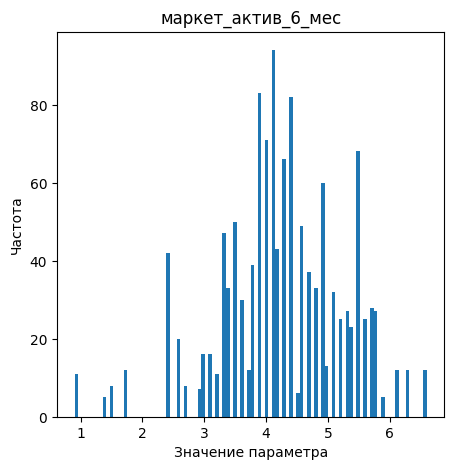

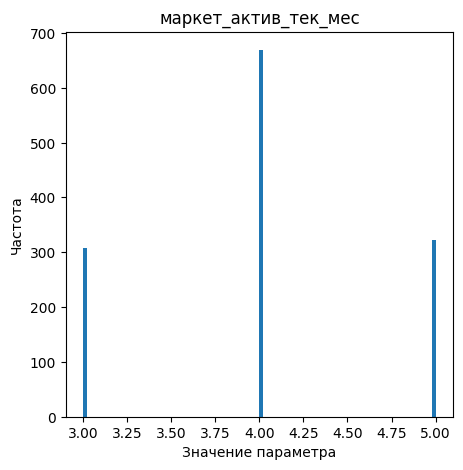

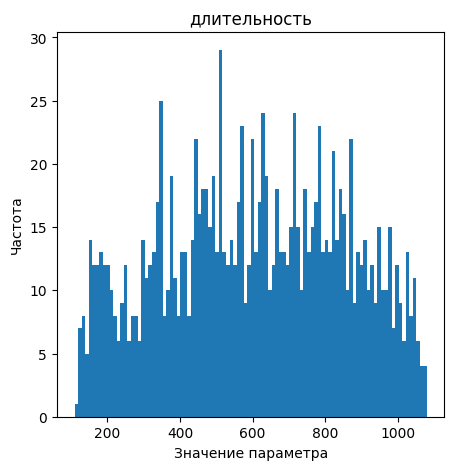

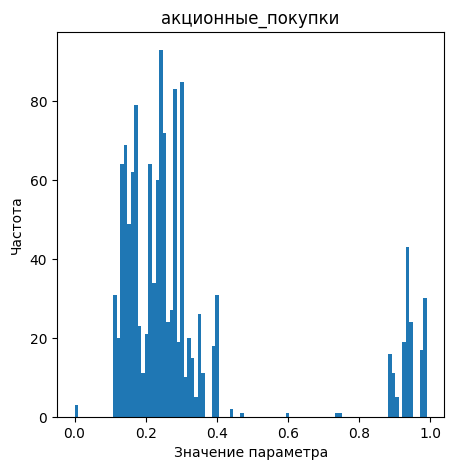

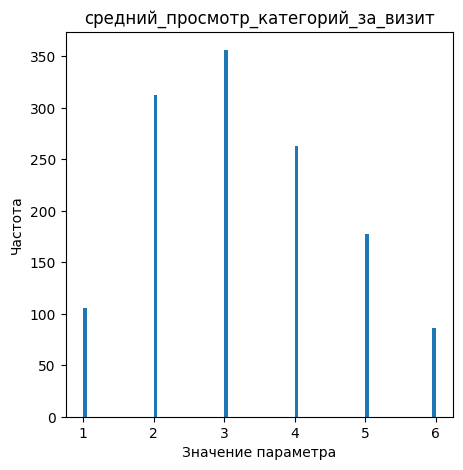

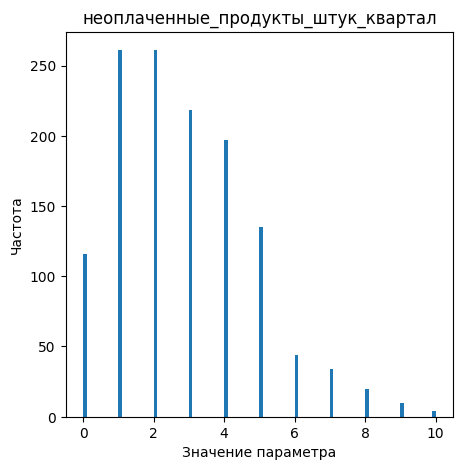

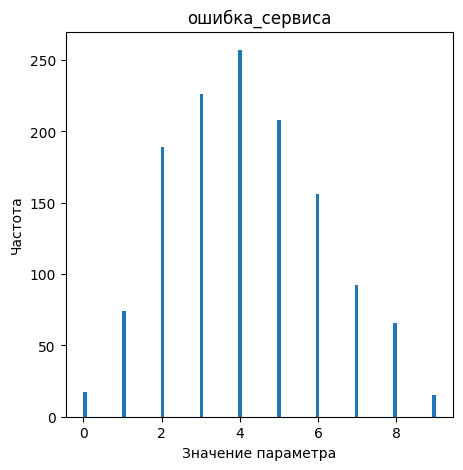

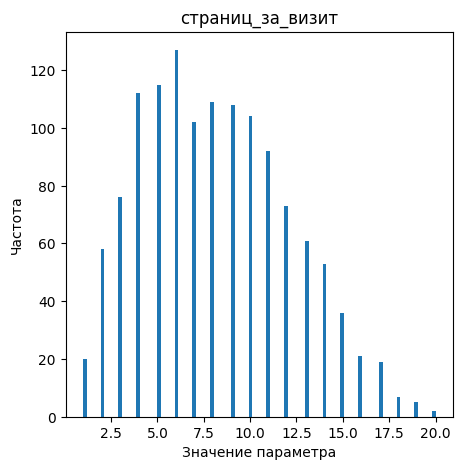

In [48]:
for col in market_file[num_cols_market_file].columns:
    market_file[col].plot(kind='hist', bins=100, figsize=(5, 5))
    plt.title(col)
    plt.xlabel('Значение параметра')
    plt.ylabel('Частота')
    plt.show()

In [49]:
market_file.describe()

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

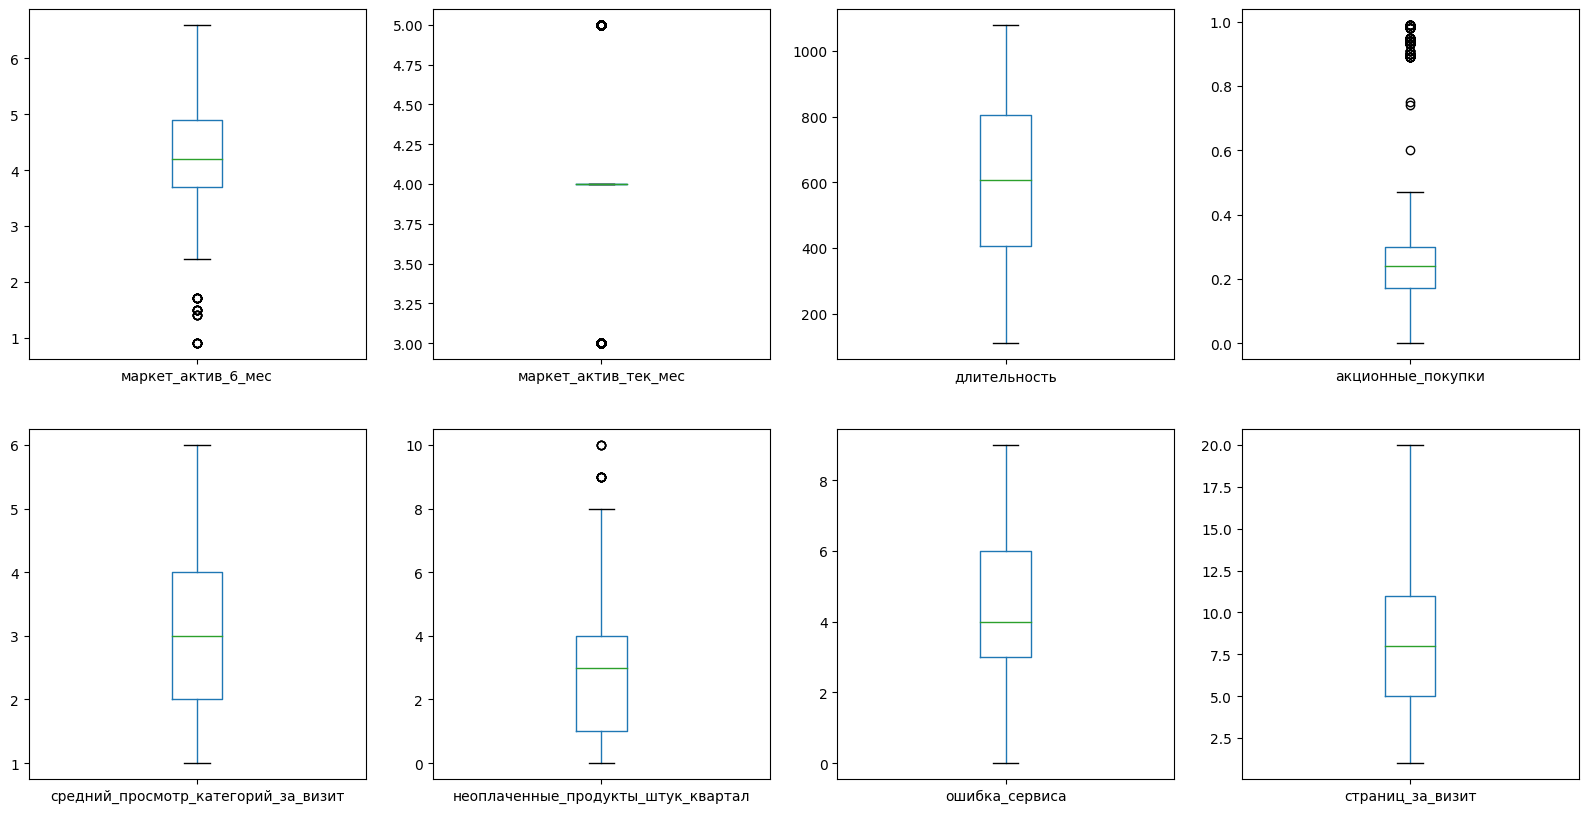

In [50]:
market_file[num_cols_market_file].plot(
    kind='box',
    subplots=True,
    layout=(2, 4),
    figsize=(20,10)
);

In [51]:
# на графиках выевил аномальное значение 
market_money.query('выручка>100000')

id период_выручка   выручка
98  215380  текущий_месяц  106862.2

In [52]:
# заменим это значения на средние текущего месяца
market_money.loc[98, 'выручка'] = market_money.query('период_выручка == "текущий_месяц"')['выручка'].mean()

In [53]:
market_money.query('id==215380')

id        период_выручка      выручка
96  215380  предпредыдущий_месяц  5051.000000
97  215380      предыдущий_месяц  6077.000000
98  215380         текущий_месяц  5314.960846

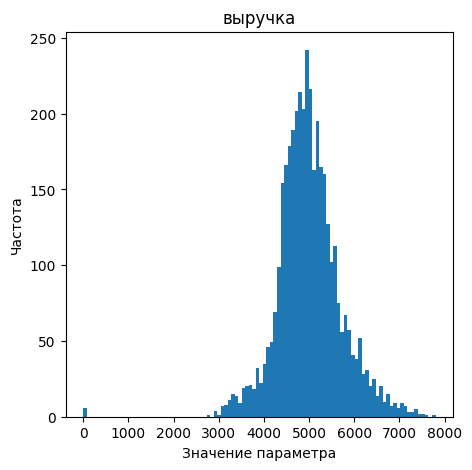

In [54]:
market_money['выручка'].plot(kind='hist', bins=100, figsize=(5, 5))
plt.title('выручка')
plt.xlabel('Значение параметра')
plt.ylabel('Частота')
plt.show()

In [55]:
market_money.describe()

id      выручка
count    3900.000000  3900.000000
mean   215997.500000  4999.658298
std       375.325686   706.927249
min    215348.000000     0.000000
25%    215672.750000  4590.150000
50%    215997.500000  4957.500000
75%    216322.250000  5363.000000
max    216647.000000  7799.400000

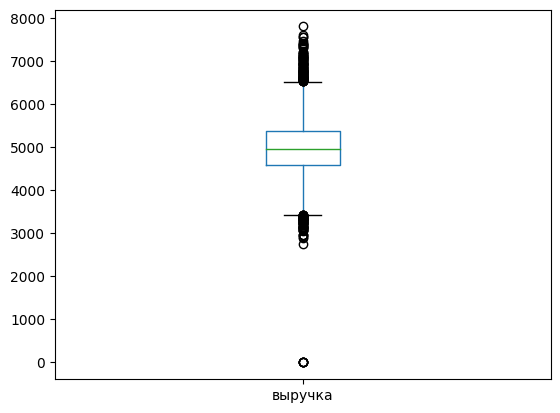

In [56]:
market_money['выручка'].plot(kind='box', subplots=True);

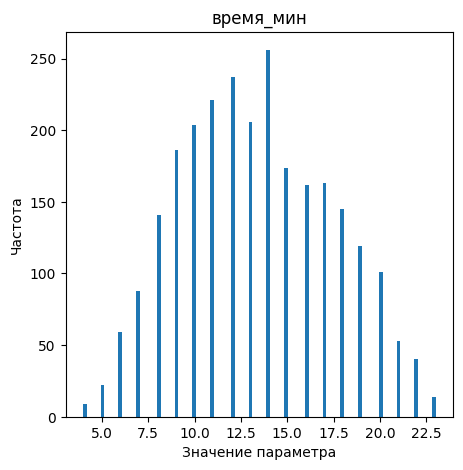

In [57]:
market_time['время_мин'].plot(kind='hist', bins=100, figsize=(5, 5))
plt.title('время_мин')
plt.xlabel('Значение параметра')
plt.ylabel('Частота')
plt.show()

In [58]:
market_time.describe()

id    время_мин
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

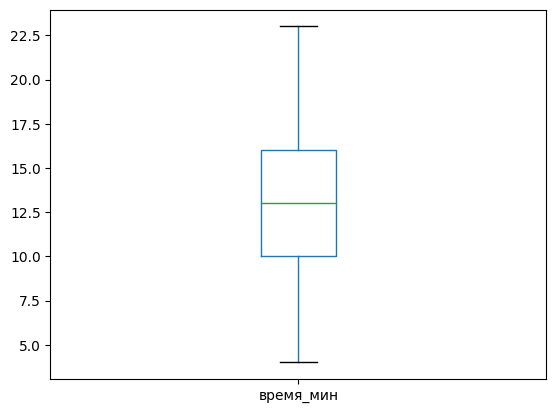

In [59]:
market_time['время_мин'].plot(kind='box', subplots=True);

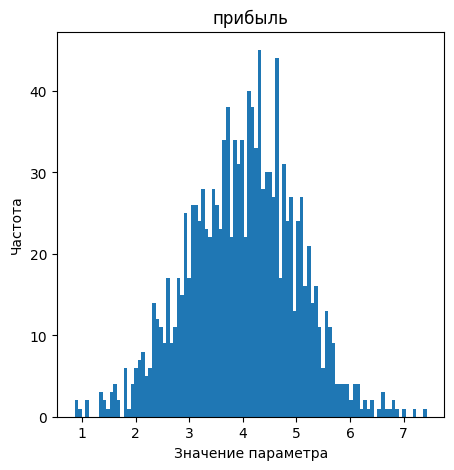

In [60]:
money['прибыль'].plot(kind='hist', bins=100, figsize=(5, 5))
plt.title('прибыль')
plt.xlabel('Значение параметра')
plt.ylabel('Частота')
plt.show()

In [61]:
money.describe()

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

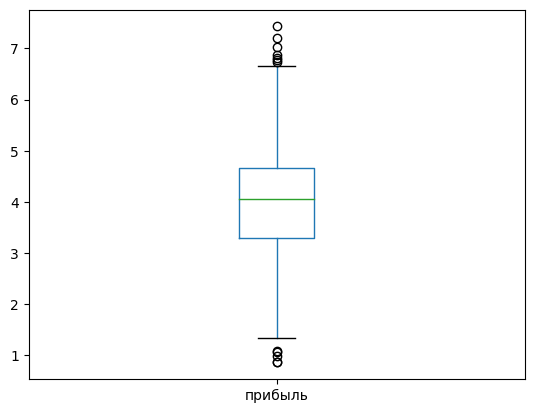

In [62]:
money['прибыль'].plot(kind='box', subplots=True);

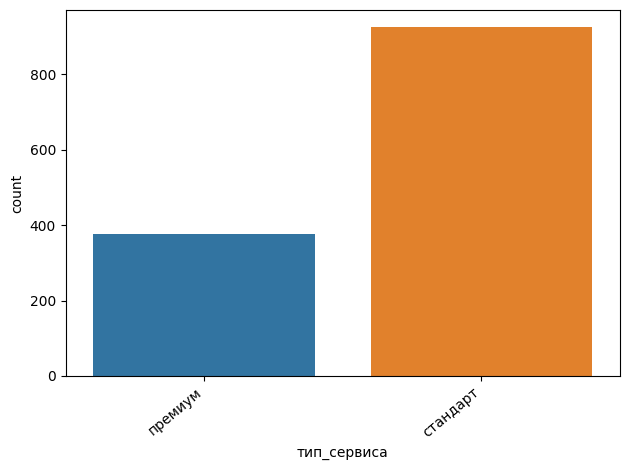

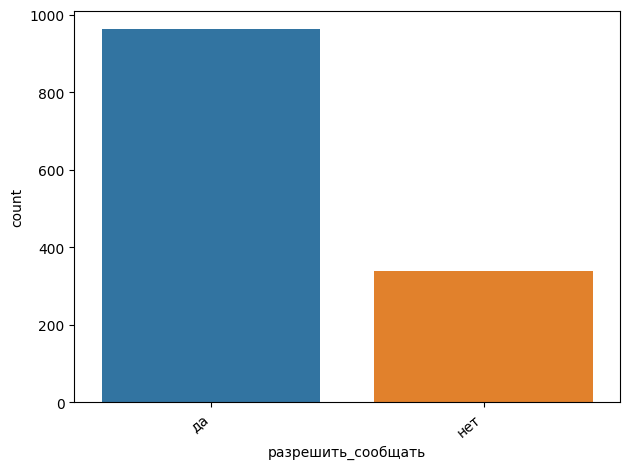

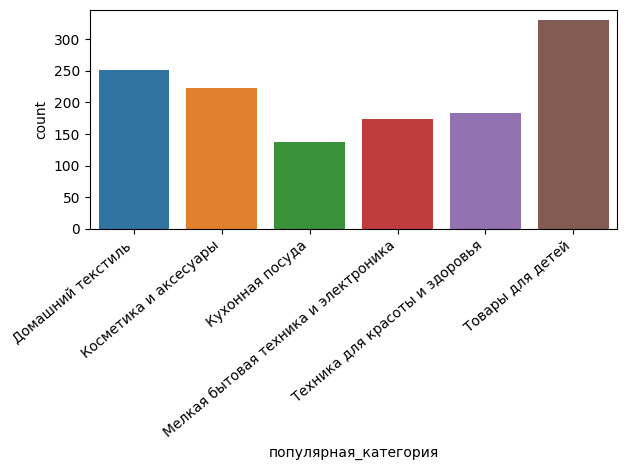

In [63]:
# Категориальные признаки
for col in cat_cols_market_file:  
    ax=sns.countplot(x=col, data = market_file)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

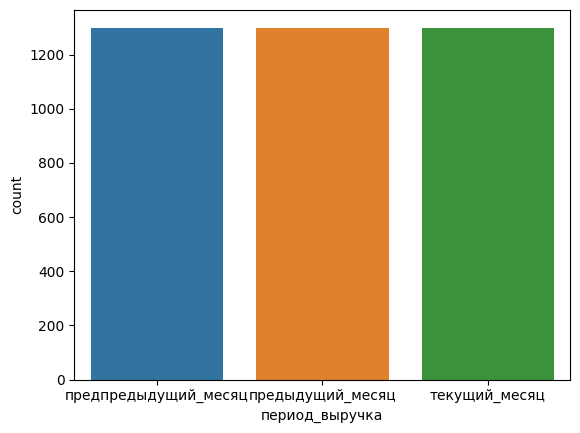

In [64]:
sns.countplot(x='период_выручка', data=market_money);

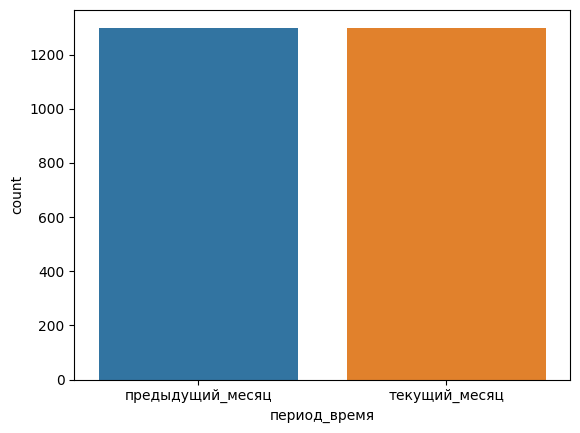

In [65]:
sns.countplot(x='период_время', data=market_time);

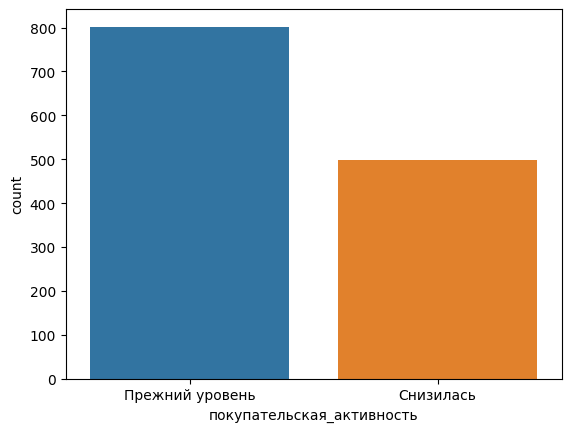

In [66]:
# посмотрим на целевой признак
sns.countplot(x='покупательская_активность', data=market_file);

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично!  Развернули таблицы.</font>

In [67]:
# Отберм клиентов с покупательской активностью не менее трёх месяцев
market_money_zero = market_money.pivot_table(index='id', columns='период_выручка', values='выручка')
market_money_zero.columns = ['выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']
market_money_zero.query('выручка_предпредыдущий_месяц == 0 or выручка_предыдущий_месяц==0 or выручка_текущий_месяц==0')

выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
id                                                               
215348                           0.0                       0.0   
215357                           0.0                       0.0   
215359                           0.0                       0.0   

        выручка_текущий_месяц  
id                             
215348                 3293.1  
215357                 5986.3  
215359                 4735.0

In [68]:
market_money = market_money[(market_money['id']!=215348)]
market_money = market_money[(market_money['id']!=215357)]
market_money = market_money[(market_money['id']!=215359)]
market_money.shape

(3891, 3)

Выводы по гистограммам и/или боксплотам
* аукционные покупки - бимодальное распределение. Делятся на 2 категории - скорее всего это покупатели, которые увлечены акциями и те для которых акция не главное.
* остальные количественные признаки относительно нормально распределены
* по describe и боксплотам - есть выбросы 6мес, актив, акции, выручка, прибыль
* целевой признак - разный уровень распределения - в 1,5 раза
* популярных категория 5 значений
* все клиенты активны не менее 3х месецев

## Объединение таблиц

In [69]:
# создадим отдельный столбец для каждого периода.
market_money = market_money.pivot_table(index='id', columns='период_выручка', values='выручка')
market_money.columns = ['выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']
market_money.head()

выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
id                                                               
215349                        4472.0                    5216.0   
215350                        4826.0                    5457.5   
215351                        4793.0                    6158.0   
215352                        4594.0                    5807.5   
215353                        5124.0                    4738.5   

        выручка_текущий_месяц  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4  
215352                 5872.5  
215353                 5388.5

In [70]:
market_time = market_time.pivot_table(index='id', columns='период_время', values='время_мин')
market_time.columns = ['время_предыдущий_месяц', 'время_текущий_месяц']
market_time.head()

время_предыдущий_месяц  время_текущий_месяц
id                                                 
215348                      13                   14
215349                      12                   10
215350                       8                   13
215351                      11                   13
215352                       8                   11

In [71]:
market_file = market_money.merge(market_file, on='id', how='left').merge(market_time, on='id', how='left')
market_file.head()

id  выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
0  215349                        4472.0                    5216.0   
1  215350                        4826.0                    5457.5   
2  215351                        4793.0                    6158.0   
3  215352                        4594.0                    5807.5   
4  215353                        5124.0                    4738.5   

   выручка_текущий_месяц покупательская_активность тип_сервиса  \
0                 4971.6                 Снизилась     премиум   
1                 5058.4                 Снизилась    стандарт   
2                 6610.4                 Снизилась    стандарт   
3                 5872.5                 Снизилась    стандарт   
4                 5388.5                 Снизилась    стандарт   

  разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
0                 да                 4.4                     4           819   
1                нет                 4.9                     3           539   
2                 да                 3.2                     5           896   
3                нет                 5.1                     3          1064   
4                 да                 3.3                     4           762   

   акционные_покупки популярная_категория  \
0               0.75     Товары для детей   
1               0.14    Домашний текстиль   
2               0.99     Товары для детей   
3               0.94     Товары для детей   
4               0.26    Домашний текстиль   

   средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
0                                    4                                   4   
1                                    5                                   2   
2                                    5                                   0   
3                                    3                                   2   
4                                    4                                   1   

   ошибка_сервиса  страниц_за_визит  время_предыдущий_месяц  \
0               2                 5                      12   
1               1                 5                       8   
2               6                 4                      11   
3               3                 2                       8   
4               1                 4                      10   

   время_текущий_месяц  
0                   10  
1                   13  
2                   13  
3                   11  
4                   10

In [72]:
market_file.shape

(1297, 18)

Объединил таблицы market_file.csv, market_money.csv, market_time.csv с учетом того что в market_money удалил менее активных покупателей

## Корреляционный анализ

In [73]:
# признак 'id' уберем в индекс
market_file = market_file.set_index('id')
market_file.head()

выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
id                                                               
215349                        4472.0                    5216.0   
215350                        4826.0                    5457.5   
215351                        4793.0                    6158.0   
215352                        4594.0                    5807.5   
215353                        5124.0                    4738.5   

        выручка_текущий_месяц покупательская_активность тип_сервиса  \
id                                                                    
215349                 4971.6                 Снизилась     премиум   
215350                 5058.4                 Снизилась    стандарт   
215351                 6610.4                 Снизилась    стандарт   
215352                 5872.5                 Снизилась    стандарт   
215353                 5388.5                 Снизилась    стандарт   

       разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  \
id                                                                    
215349                 да                 4.4                     4   
215350                нет                 4.9                     3   
215351                 да                 3.2                     5   
215352                нет                 5.1                     3   
215353                 да                 3.3                     4   

        длительность  акционные_покупки популярная_категория  \
id                                                             
215349           819               0.75     Товары для детей   
215350           539               0.14    Домашний текстиль   
215351           896               0.99     Товары для детей   
215352          1064               0.94     Товары для детей   
215353           762               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        время_предыдущий_месяц  время_текущий_месяц  
id                                                   
215349                      12                   10  
215350                       8                   13  
215351                      11                   13  
215352                       8                   11  
215353                      10                   10

In [74]:
num_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
    'время_предыдущий_месяц', 'время_текущий_месяц'
]
target = 'покупательская_активность'

In [75]:
market_file[num_columns].corr(method='spearman')

маркет_актив_6_мес  маркет_актив_тек_мес  \
маркет_актив_6_мес                             1.000000              0.061697   
маркет_актив_тек_мес                           0.061697              1.000000   
длительность                                  -0.044614             -0.131979   
акционные_покупки                             -0.277968              0.033045   
средний_просмотр_категорий_за_визит            0.185027             -0.025158   
неоплаченные_продукты_штук_квартал            -0.134368              0.061754   
ошибка_сервиса                                 0.038656              0.087351   
страниц_за_визит                               0.319918              0.003144   
выручка_предпредыдущий_месяц                   0.233325             -0.039397   
выручка_предыдущий_месяц                      -0.005652             -0.027107   
выручка_текущий_месяц                          0.001768             -0.011781   
время_предыдущий_месяц                         0.274003              0.013538   
время_текущий_месяц                            0.226345             -0.063044   

                                     длительность  акционные_покупки  \
маркет_актив_6_мес                      -0.044614          -0.277968   
маркет_актив_тек_мес                    -0.131979           0.033045   
длительность                             1.000000           0.029186   
акционные_покупки                        0.029186           1.000000   
средний_просмотр_категорий_за_визит     -0.043150          -0.203380   
неоплаченные_продукты_штук_квартал      -0.108822           0.197624   
ошибка_сервиса                           0.103528          -0.051590   
страниц_за_визит                        -0.034591          -0.370853   
выручка_предпредыдущий_месяц            -0.039284          -0.267790   
выручка_предыдущий_месяц                 0.013739           0.007035   
выручка_текущий_месяц                    0.015045           0.022559   
время_предыдущий_месяц                  -0.124000          -0.332743   
время_текущий_месяц                      0.083035          -0.274693   

                                     средний_просмотр_категорий_за_визит  \
маркет_актив_6_мес                                              0.185027   
маркет_актив_тек_мес                                           -0.025158   
длительность                                                   -0.043150   
акционные_покупки                                              -0.203380   
средний_просмотр_категорий_за_визит                             1.000000   
неоплаченные_продукты_штук_квартал                             -0.251448   
ошибка_сервиса                                                  0.010034   
страниц_за_визит                                                0.267536   
выручка_предпредыдущий_месяц                                    0.149619   
выручка_предыдущий_месяц                                       -0.049596   
выручка_текущий_месяц                                          -0.070743   
время_предыдущий_месяц                                          0.148376   
время_текущий_месяц                                             0.233358   

                                     неоплаченные_продукты_штук_квартал  \
маркет_актив_6_мес                                            -0.134368   
маркет_актив_тек_мес                                           0.061754   
длительность                                                  -0.108822   
акционные_покупки                                              0.197624   
средний_просмотр_категорий_за_визит                           -0.251448   
неоплаченные_продукты_штук_квартал                             1.000000   
ошибка_сервиса                                                -0.098544   
страниц_за_визит                                              -0.165297   
выручка_предпредыдущий_месяц                                  -0.249421   
выручка_предыдущий_месяц                                       0.032958   
выр

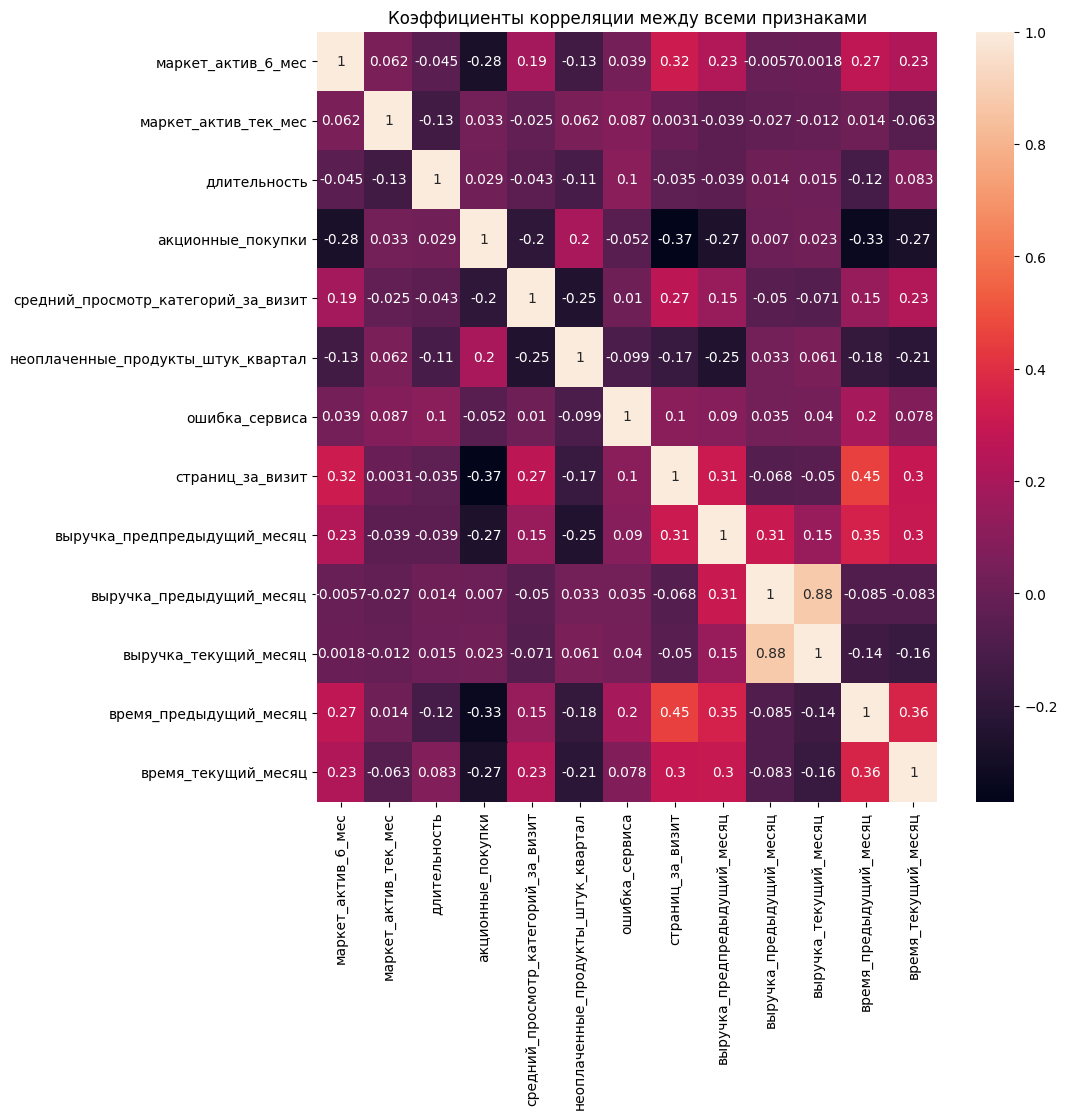

In [76]:
plt.figure(figsize=(10,10))
sns.heatmap(market_file[num_columns].corr(method='spearman'), annot=True)
plt.title('Коэффициенты корреляции между всеми признаками');

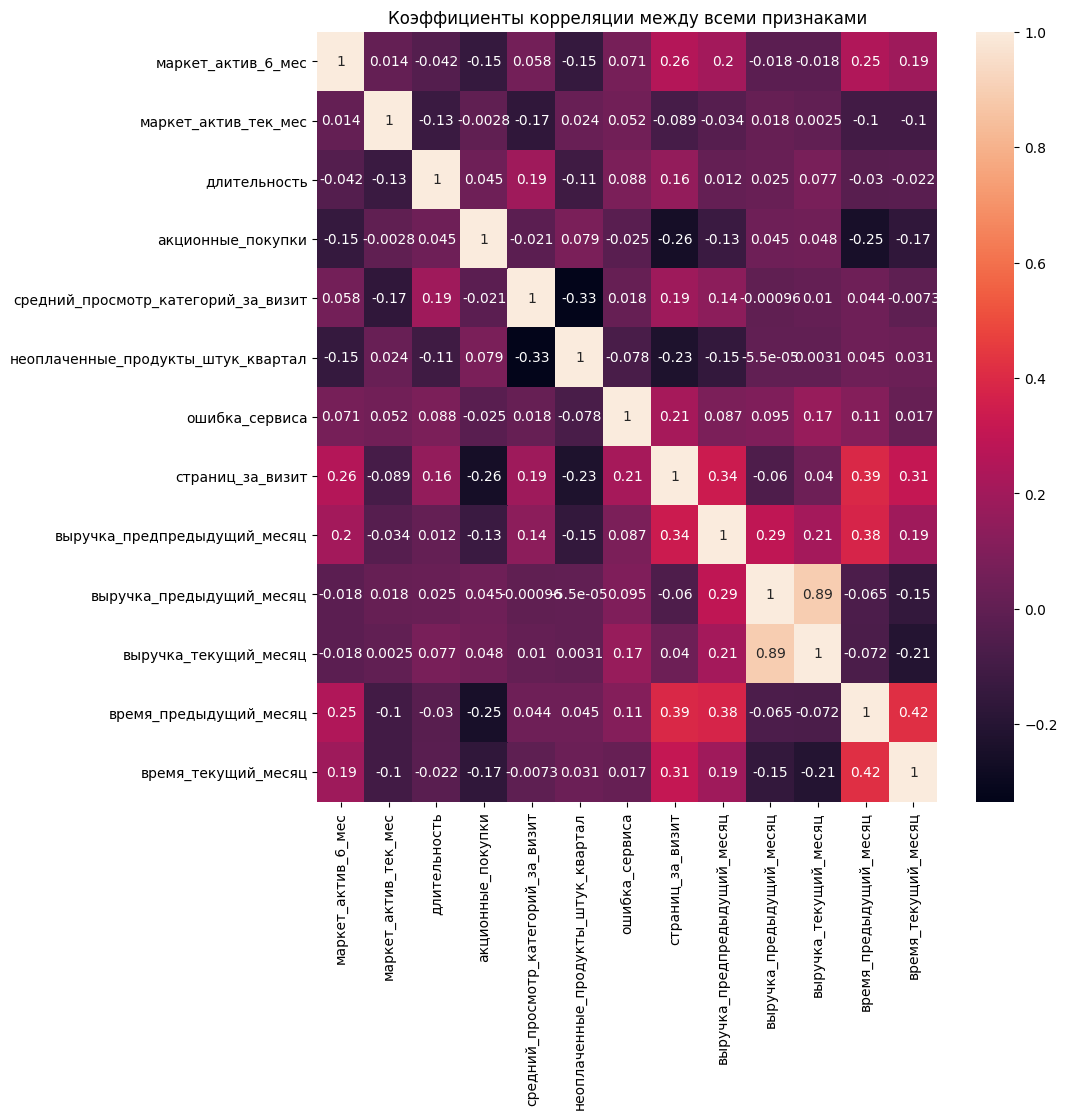

In [77]:
# Посмотрим отдельно корреляцию признаков для покупателей с активность снизилась
plt.figure(figsize=(10,10))
sns.heatmap(market_file.query('покупательская_активность=="Снизилась"')[num_columns].corr(method='spearman'), annot=True)
plt.title('Коэффициенты корреляции между всеми признаками');

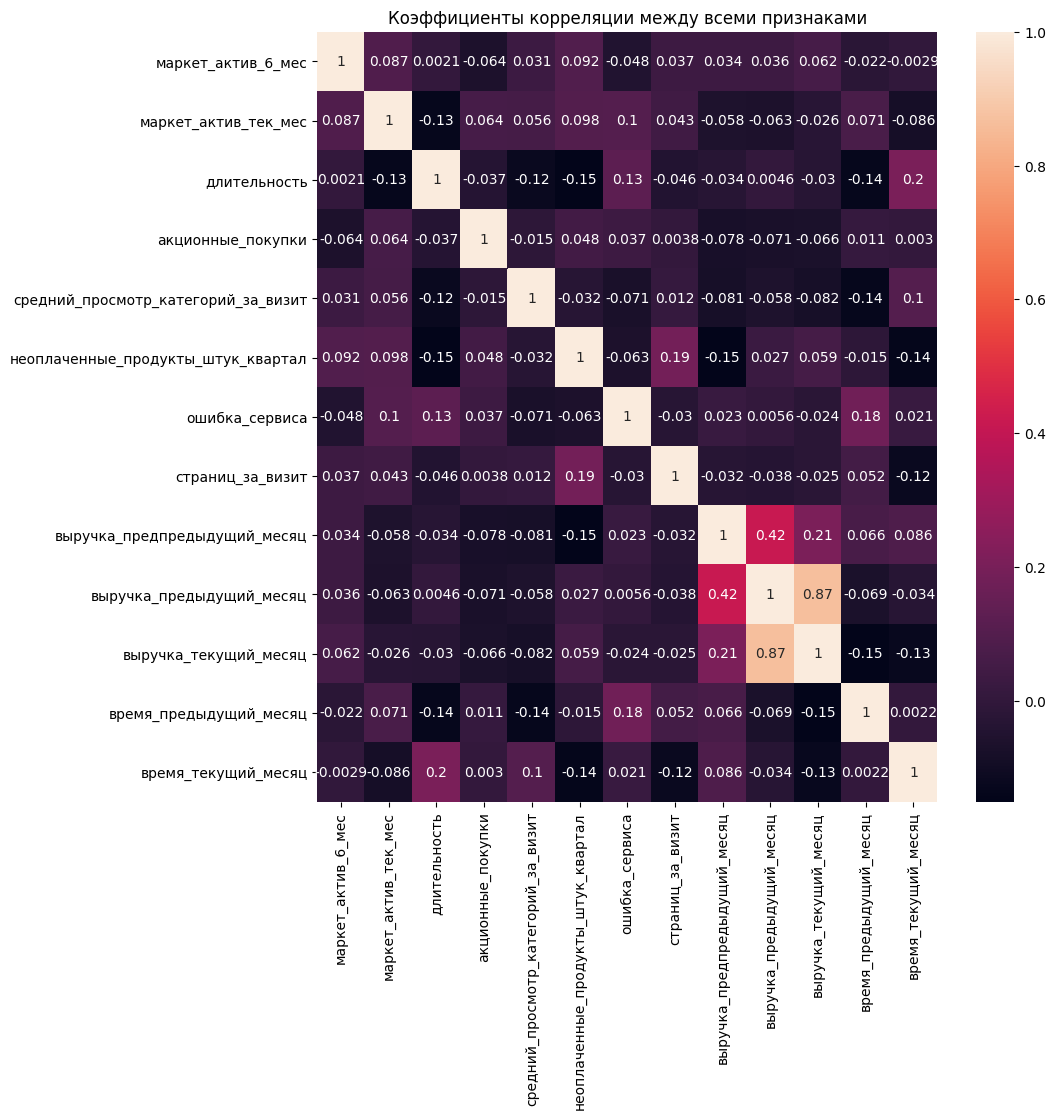

In [78]:
# Посмотрим отдельно корреляцию признаков для покупателей с активность на преженем уровне
plt.figure(figsize=(10,10))
sns.heatmap(market_file.query('покупательская_активность=="Прежний уровень"')[num_columns].corr(method='spearman'), annot=True)
plt.title('Коэффициенты корреляции между всеми признаками');

In [79]:
num_cols2 = [
    'маркет_актив_6_мес', 'длительность', 'акционные_покупки',
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'время_предыдущий_месяц', 'время_текущий_месяц'
]

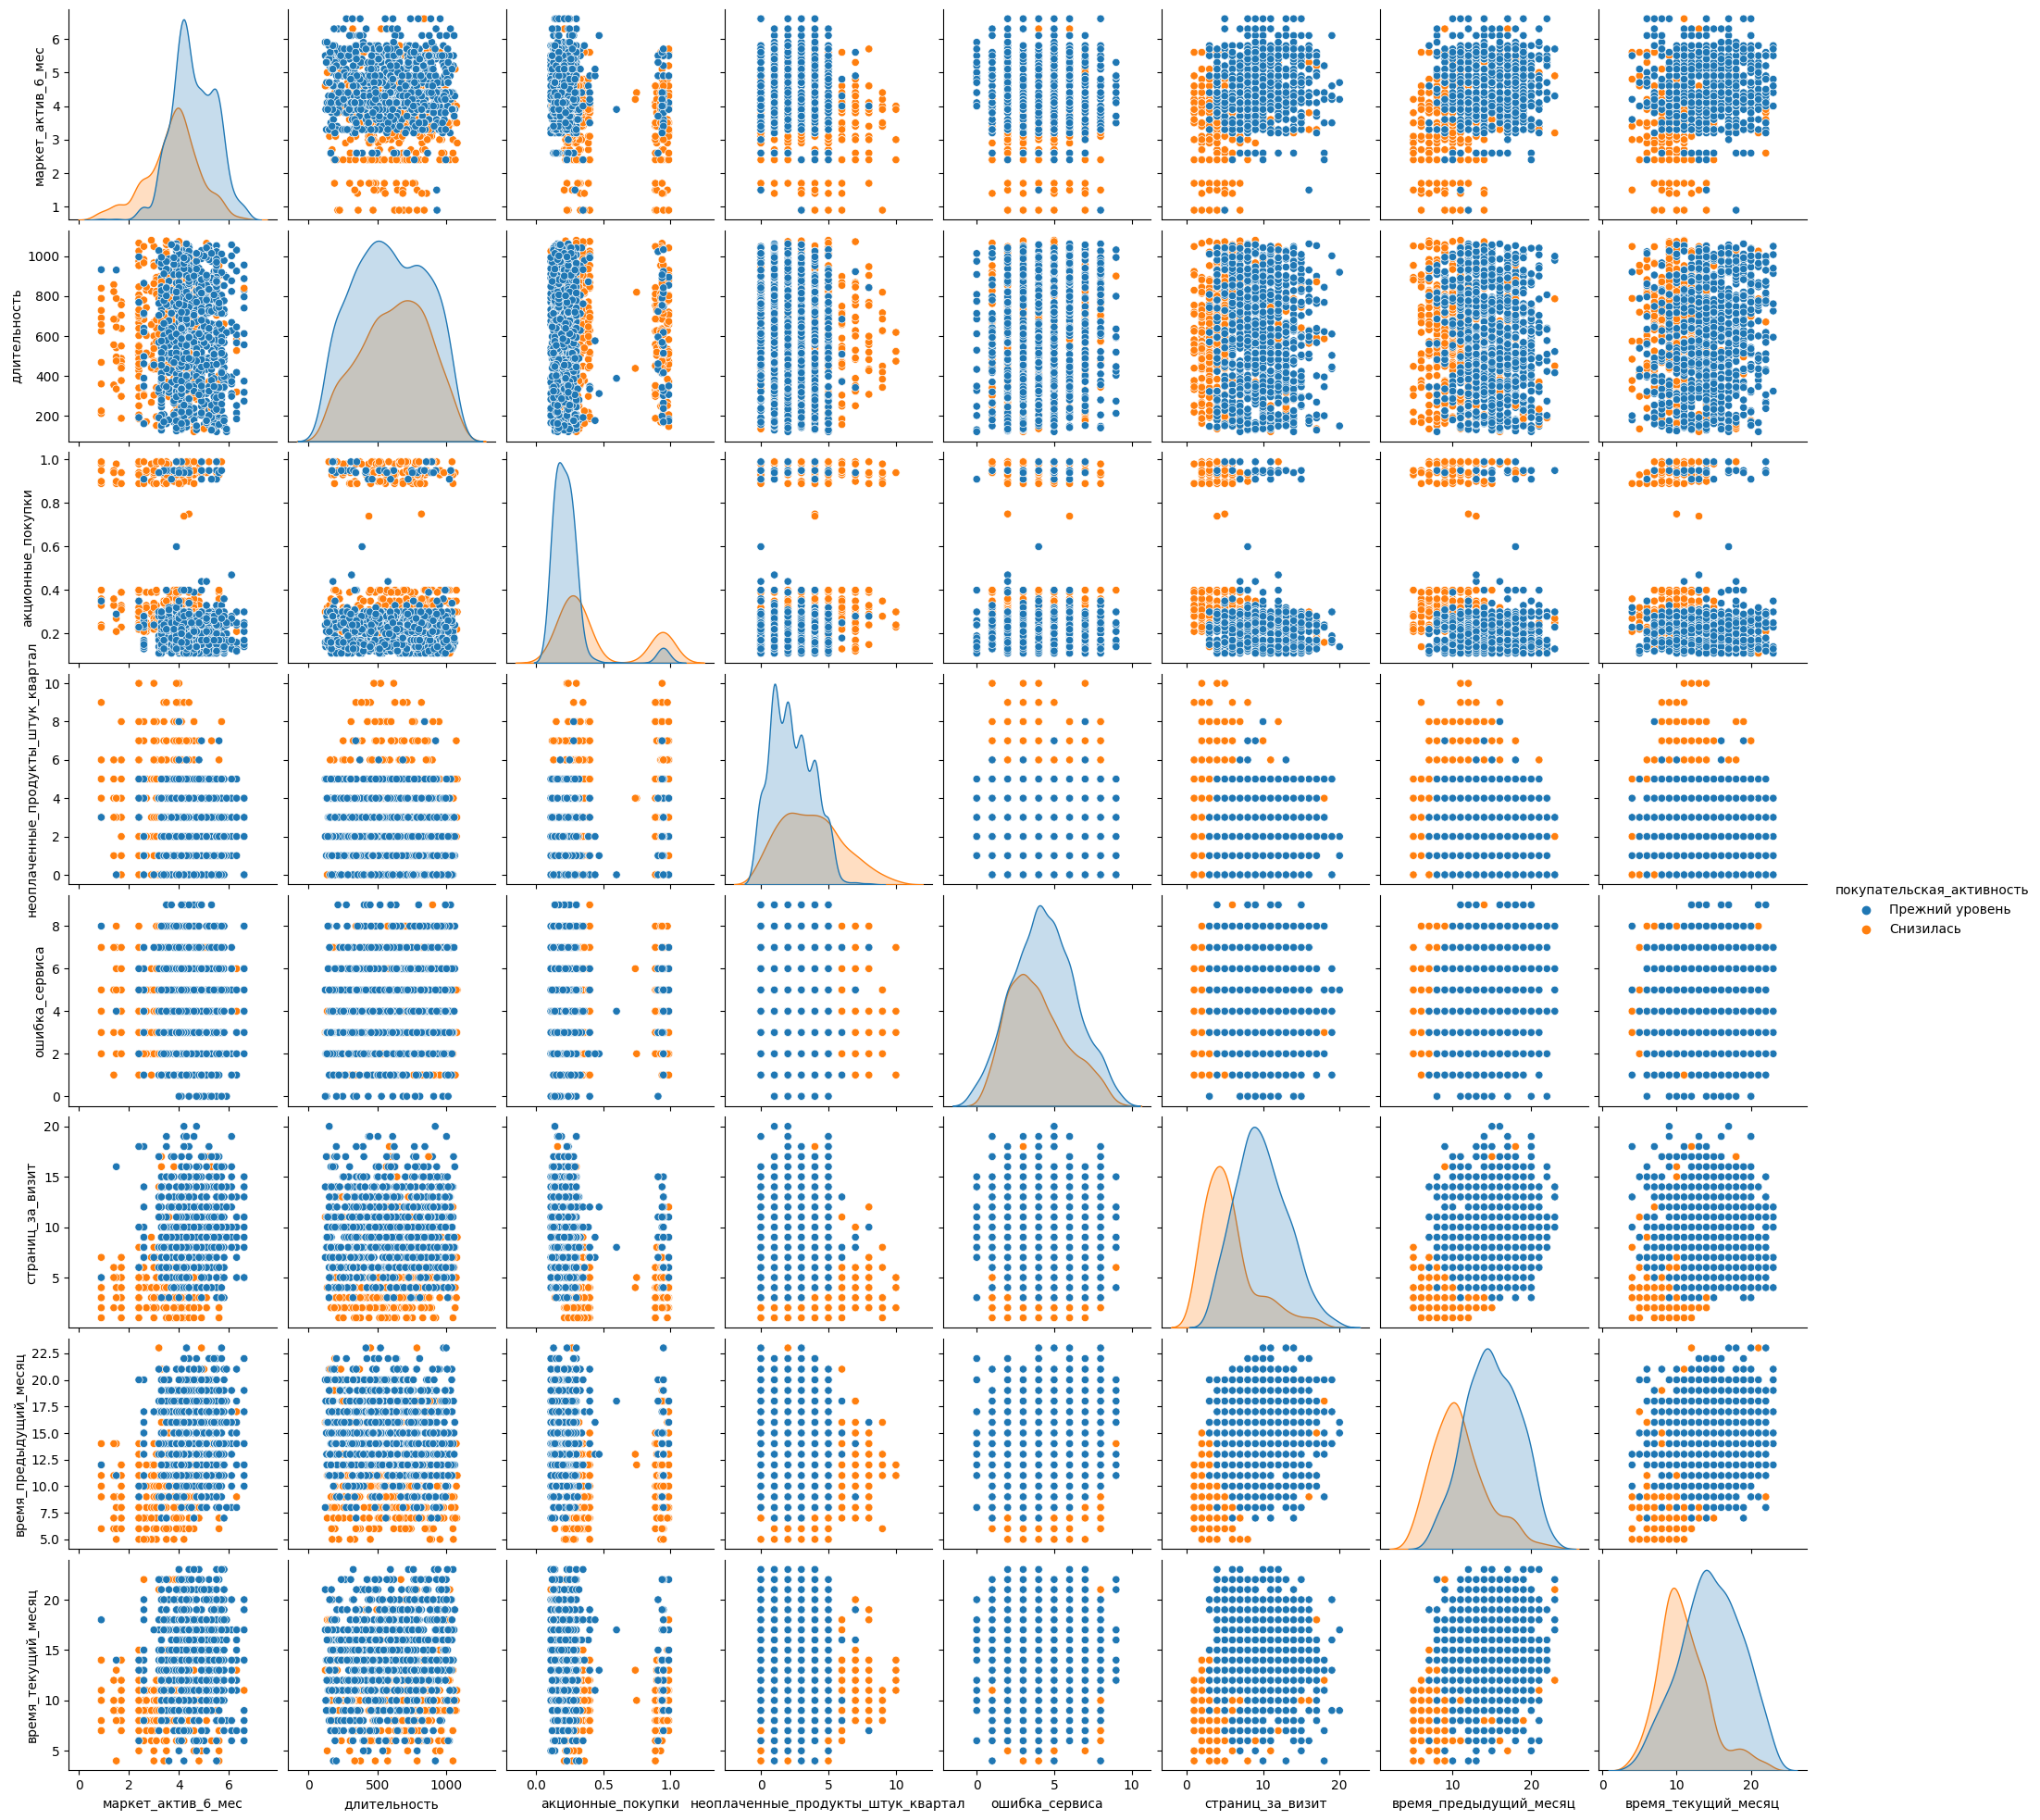

In [80]:
#Выборочно провожу графический анализ взаимосвязи факторов 
sns.pairplot(data=market_file[num_cols2+[target]], hue=target);

Очень высоких корреляций (0.9 +) не видно, скорее всего мультиколлинеарности нет

## Использование пайплайнов

In [81]:
# загружаем данные
X_train, X_test, y_train, y_test = train_test_split(
    market_file.drop('покупательская_активность', axis=1),
    market_file['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_file['покупательская_активность']
)

In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 215858 to 216030
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   выручка_предпредыдущий_месяц         972 non-null    float64 
 1   выручка_предыдущий_месяц             972 non-null    float64 
 2   выручка_текущий_месяц                972 non-null    float64 
 3   тип_сервиса                          972 non-null    category
 4   разрешить_сообщать                   972 non-null    category
 5   маркет_актив_6_мес                   972 non-null    float64 
 6   маркет_актив_тек_мес                 972 non-null    int64   
 7   длительность                         972 non-null    int64   
 8   акционные_покупки                    972 non-null    float64 
 9   популярная_категория                 972 non-null    category
 10  средний_просмотр_категорий_за_визит  972 non-null    int64   
 11  неоплаченны

In [83]:
# кодирую целевой признак
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_label = label_encoder.transform(y_train)
y_test_label = label_encoder.transform(y_test) 

In [84]:
pd.DataFrame(y_train_label, y_train, columns=['LabelEncoder']).head()

LabelEncoder
покупательская_активность              
Прежний уровень                       0
Снизилась                             1
Прежний уровень                       0
Прежний уровень                       0
Снизилась                             1

In [85]:
y_train = y_train_label
y_test = y_test_label

In [86]:
# создаём списки с названиями признаков
ohe_ord_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит',
    'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц',
    'время_предыдущий_месяц', 'время_текущий_месяц'
]

In [87]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe_ord', OneHotEncoder(drop='first', sparse=False), ohe_ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [88]:
# итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [89]:
# подготовка данных
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1', max_iter=100)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe_ord': [OneHotEncoder(drop='first', sparse=False)]
    },
    {
        'models': [SVC(kernel='linear', probability= True, random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10, 100],  
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe_ord': [OneHotEncoder(drop='first', sparse=False)]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__ohe_ord': [OrdinalEncoder()]
    },
    {
        # название модели
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe_ord': [OneHotEncoder(drop='first', sparse=False)]
    }
]

In [90]:
# модель
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train)
y_pred = randomized_search.predict(X_test)
probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_ord',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за

In [91]:
# соберем лучшую модель
ohe = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[ohe_ord_columns])
X_test_ohe = ohe.transform(X_test[ohe_ord_columns])
ohe_col_names = ohe.get_feature_names()

In [92]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

In [93]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

In [94]:
index_train = X_train.index
index_test = X_test.index

In [95]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1).set_index(index_train)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1).set_index(index_test)

In [96]:
model = LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
preds = model.predict_proba(X_test)

Для выбора лучшей модели построил пайплайн.

Будем считать метрику roc_auc. Она лучше работает при дисбалансе целевого признака. Раз в данных есть дисбаланс классов, нужно обязательно выполнить стратификацию по целевому признаку.

Для кодирования категориальных признаков спользовал OneHotEncoder и OrdinalEncoder. Для целевого LabelEncoder.

Целовой признак вот так закодирован: Снизилась 1   Прежний уровень 0

Для масштабирования количественных признаков выбор из 2х сколяров StandardScaler и MinMaxScaler

Обучил три модели: DecisionTreeClassifier(), LogisticRegression() и  SVC() с разными гиперпораметроми.

Лучшая модель: DecisionTreeClassifier(max_depth=4, max_features=3) Маштабирование MinMaxScaler

## Анализ важности признаков

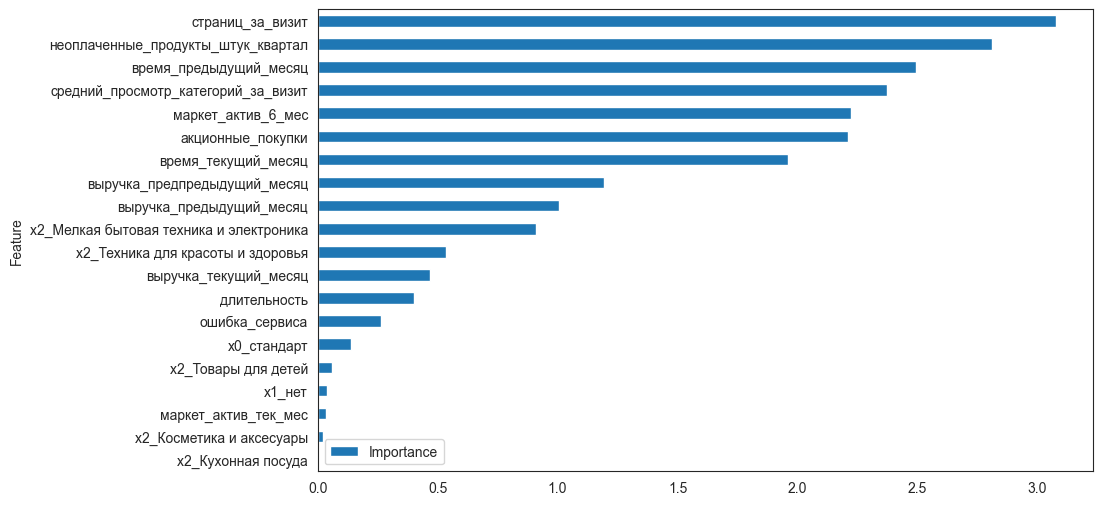

In [97]:
# строим график важности признаков по величине коэффициентов
coefficients = model.coef_[0]
sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': X_test.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

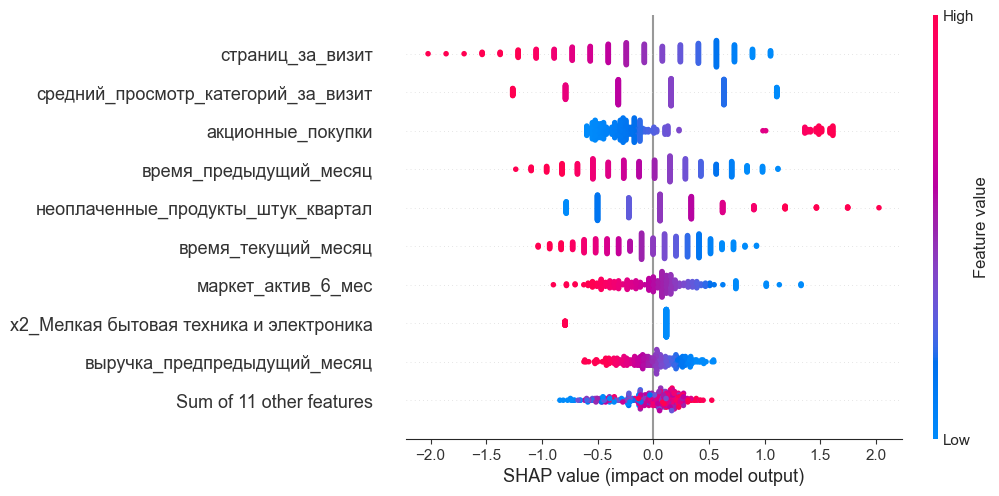

In [98]:
explainer = shap.LinearExplainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values) 

Исходя из анализа выделим Выжные признаки: 
* просмотр страниц за визит - при больших значениях склонят к 0 прежний уровень и наоборот
* акционные покупки при маленьких значениях положительный эффект - при больших эффект разный
* время на сайте за этот и прошлый месяц при больших значениях положительный эффект и наоборот
* неоплаченые продукты при больших значениях отрицательный эффект и наоборот
* маркетинг при больших значениях положительный эффект и наоборот
Признаки популярные категории, ошибки на сайте, длительность, тип сервиса малозначимы для модели

Используя важные признаки модели и их интерпритацию можно выделить группу покупателей и понять как увеличить их покупательскую активность.

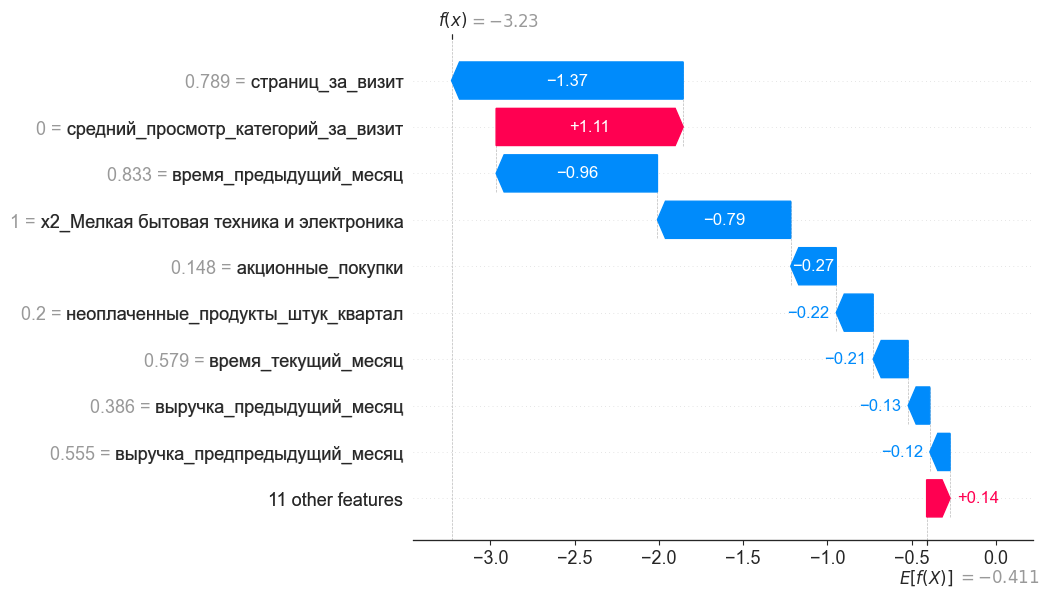

In [99]:
shap.plots.waterfall(shap_values[91])

## Сегментация покупателей

Выделим среди покупателей секмент: группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Считаю это сегмент очень важним для бизнеса. Можно вернуть клиентов с высокой прибыльностью.

In [100]:
X_test['вероятность_снижения'] = np.delete(preds, 0, axis=1)
X_test.head()

x0_стандарт  x1_нет  x2_Косметика и аксесуары  x2_Кухонная посуда  \
id                                                                          
216446          1.0     0.0                       0.0                 0.0   
215469          0.0     0.0                       0.0                 0.0   
216301          0.0     0.0                       1.0                 0.0   
215713          1.0     0.0                       0.0                 0.0   
215500          1.0     0.0                       1.0                 0.0   

        x2_Мелкая бытовая техника и электроника  \
id                                                
216446                                      0.0   
215469                                      0.0   
216301                                      0.0   
215713                                      0.0   
215500                                      0.0   

        x2_Техника для красоты и здоровья  x2_Товары для детей  \
id                                                               
216446                                1.0                  0.0   
215469                                0.0                  0.0   
216301                                0.0                  0.0   
215713                                0.0                  1.0   
215500                                0.0                  0.0   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  ...  \
id                                                              ...   
216446            0.771930                   1.0      0.325678  ...   
215469            0.561404                   0.0      0.722338  ...   
216301            0.526316                   1.0      0.301670  ...   
215713            0.649123                   1.0      0.179541  ...   
215500            0.456140                   0.5      0.471816  ...   

        средний_просмотр_категорий_за_визит  \
id                                            
216446                                  0.0   
215469                                  0.4   
216301                                  0.4   
215713                                  0.0   
215500                                  0.2   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216446                                 0.1        0.000000          0.315789   
215469                                 0.3        0.444444          0.210526   
216301                                 0.1        0.555556          0.684211   
215713                                 0.3        0.333333          0.105263   
215500                                 0.4        0.111111          0.157895   

        выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
id                                                               
216446                      0.677771                  0.448139   
215469                      0.504164                  0.625016   
216301                      0.798206                  0.535235   
215713                      0.493274                  0.476020   
215500                      0.112748                  0.301062   

        выручка_текущий_месяц  время_предыдущий_месяц  время_текущий_месяц  \
id                                                                           
216446               0.490408                0.555556             0.842105   
215469               0.489872                0.388889             0.210526   
216301               0.430039                0.666667             0.473684   
215713               0.488563                0.388889             0.526316   
215500               0.208185                0.333333             0.421053   

        вероятность_снижения  
id                            
216446              0.443221  
215469              0.708478  
216301              0.051471  
215713              0.765931  
215500              0.931579  

[5 rows x 21 columns]

In [101]:
X_test = X_test.merge(money, on='id', how='left')
X_test.head()

id  x0_стандарт  x1_нет  x2_Косметика и аксесуары  x2_Кухонная посуда  \
0  216446          1.0     0.0                       0.0                 0.0   
1  215469          0.0     0.0                       0.0                 0.0   
2  216301          0.0     0.0                       1.0                 0.0   
3  215713          1.0     0.0                       0.0                 0.0   
4  215500          1.0     0.0                       1.0                 0.0   

   x2_Мелкая бытовая техника и электроника  x2_Техника для красоты и здоровья  \
0                                      0.0                                1.0   
1                                      0.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   x2_Товары для детей  маркет_актив_6_мес  маркет_актив_тек_мес  ...  \
0                  0.0            0.771930                   1.0  ...   
1                  0.0            0.561404                   0.0  ...   
2                  0.0            0.526316                   1.0  ...   
3                  1.0            0.649123                   1.0  ...   
4                  0.0            0.456140                   0.5  ...   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                 0.1        0.000000          0.315789   
1                                 0.3        0.444444          0.210526   
2                                 0.1        0.555556          0.684211   
3                                 0.3        0.333333          0.105263   
4                                 0.4        0.111111          0.157895   

   выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
0                      0.677771                  0.448139   
1                      0.504164                  0.625016   
2                      0.798206                  0.535235   
3                      0.493274                  0.476020   
4                      0.112748                  0.301062   

   выручка_текущий_месяц  время_предыдущий_месяц  время_текущий_месяц  \
0               0.490408                0.555556             0.842105   
1               0.489872                0.388889             0.210526   
2               0.430039                0.666667             0.473684   
3               0.488563                0.388889             0.526316   
4               0.208185                0.333333             0.421053   

   вероятность_снижения  прибыль  
0              0.443221     4.47  
1              0.708478     3.76  
2              0.051471     4.34  
3              0.765931     4.42  
4              0.931579     4.99  

[5 rows x 23 columns]

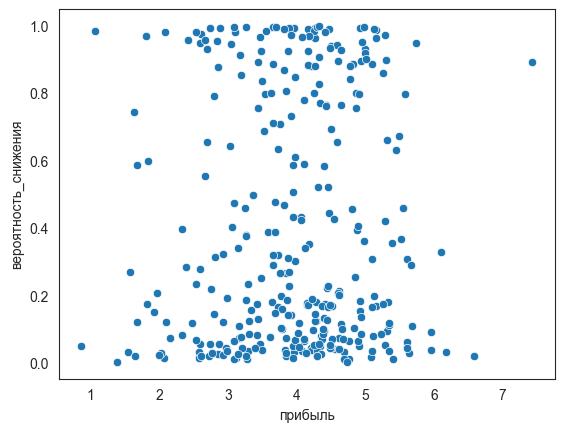

In [102]:
a = sns.scatterplot(data = X_test, x = 'прибыль', y = 'вероятность_снижения')

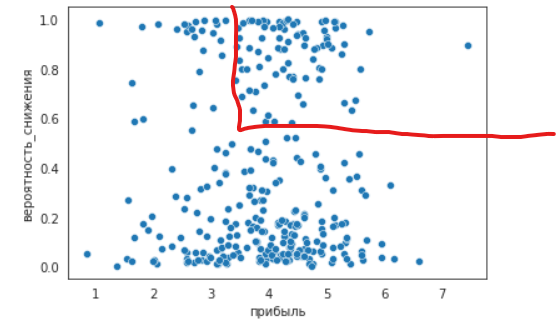

In [103]:
segment = X_test.query('прибыль > 3.5 and вероятность_снижения > 0.5' )
segment.shape

(82, 23)

In [104]:
segment.head()

id  x0_стандарт  x1_нет  x2_Косметика и аксесуары  x2_Кухонная посуда  \
1   215469          0.0     0.0                       0.0                 0.0   
3   215713          1.0     0.0                       0.0                 0.0   
4   215500          1.0     0.0                       1.0                 0.0   
8   215356          1.0     0.0                       1.0                 0.0   
19  215578          1.0     0.0                       0.0                 0.0   

    x2_Мелкая бытовая техника и электроника  \
1                                       0.0   
3                                       0.0   
4                                       0.0   
8                                       0.0   
19                                      1.0   

    x2_Техника для красоты и здоровья  x2_Товары для детей  \
1                                 0.0                  0.0   
3                                 0.0                  1.0   
4                                 0.0                  0.0   
8                                 0.0                  0.0   
19                                0.0                  0.0   

    маркет_актив_6_мес  маркет_актив_тек_мес  ...  \
1             0.561404                   0.0  ...   
3             0.649123                   1.0  ...   
4             0.456140                   0.5  ...   
8             0.578947                   0.5  ...   
19            0.263158                   0.5  ...   

    неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
1                                  0.3        0.444444          0.210526   
3                                  0.3        0.333333          0.105263   
4                                  0.4        0.111111          0.157895   
8                                  0.2        0.111111          0.105263   
19                                 0.4        0.555556          0.105263   

    выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
1                       0.504164                  0.625016   
3                       0.493274                  0.476020   
4                       0.112748                  0.301062   
8                       0.212044                  0.303491   
19                      0.433056                  0.605832   

    выручка_текущий_месяц  время_предыдущий_месяц  время_текущий_месяц  \
1                0.489872                0.388889             0.210526   
3                0.488563                0.388889             0.526316   
4                0.208185                0.333333             0.421053   
8                0.358621                0.055556             0.157895   
19               0.603686                0.277778             0.157895   

    вероятность_снижения  прибыль  
1               0.708478     3.76  
3               0.765931     4.42  
4               0.931579     4.99  
8               0.895349     4.93  
19              0.925465     3.88  

[5 rows x 23 columns]

In [105]:
segment.sort_values(by='страниц_за_визит')[['id', 'страниц_за_визит']].head()

id  страниц_за_визит
315  215579               0.0
273  215552               0.0
184  215721               0.0
121  215423               0.0
202  215461               0.0

In [106]:
X_test[(X_test['id']==215579)]

id  x0_стандарт  x1_нет  x2_Косметика и аксесуары  \
315  215579          1.0     1.0                       0.0   

     x2_Кухонная посуда  x2_Мелкая бытовая техника и электроника  \
315                 0.0                                      0.0   

     x2_Техника для красоты и здоровья  x2_Товары для детей  \
315                                0.0                  1.0   

     маркет_актив_6_мес  маркет_актив_тек_мес  ...  \
315            0.473684                   0.0  ...   

     неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
315                                 0.5        0.222222               0.0   

     выручка_предпредыдущий_месяц  выручка_предыдущий_месяц  \
315                      0.186419                   0.65392   

     выручка_текущий_месяц  время_предыдущий_месяц  время_текущий_месяц  \
315               0.683278                0.055556             0.368421   

     вероятность_снижения  прибыль  
315              0.971857     3.92  

[1 rows x 23 columns]

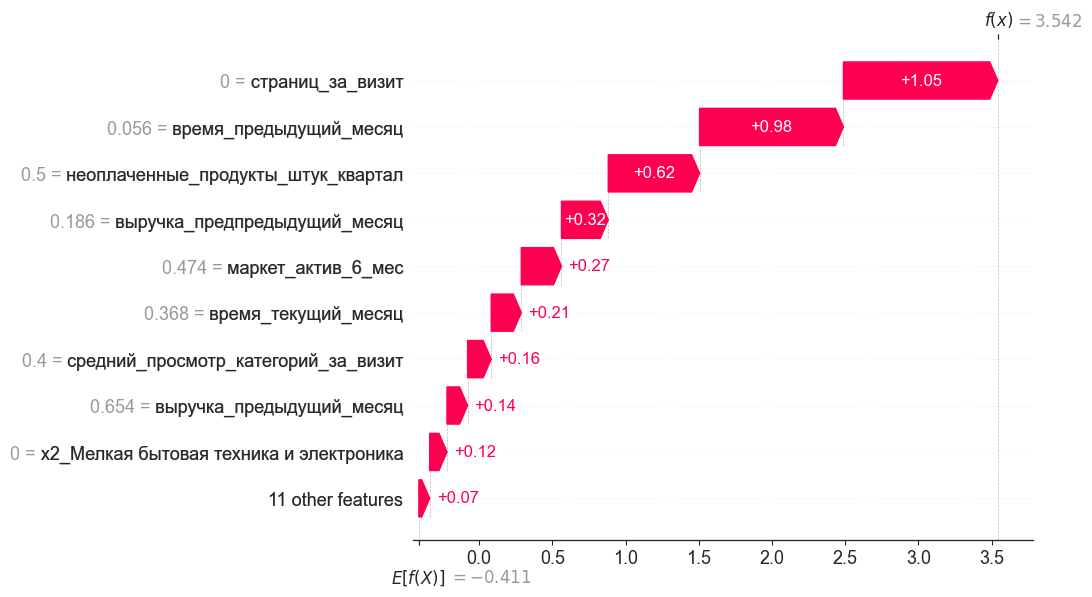

In [107]:
shap.plots.waterfall(shap_values[315])

И так на этом этапе проекта:
1. Выбрал среди покупателей секмент: группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Считаю это сегмент очень важним для бизнеса. Можно вернуть клиентов с высокой прибыльностью.
2. Этот сегмент можно получить из тестовой выборки. Добавил к ней информацию о прибыльности клиентов и вероятность снижения прибыльности, которую получил в результате работы модели. 
3. Отобразил на графике диаграмму рассеяния, где по одной оси будет результат моделирования (вероятность снижения), а по другой прибыль.
4. По шкалам графика выделил сегмент покупателей с высокой прибылью и высокой вероятностью снижения активности.
5. В моем сегменте можно выделить покупателей с низким количеством страниц при посещении. В прошлом шаге я выяснил это очень важный признак.
6. На графике 'водопад' видно, что у клиента 215579 признак со страницами сильно влияет на покупательскую активность.

Предлагаю клиентам из моего сегмента с низкой посещаемостью направить персонолизированые предложения, которые замотивируют клиентов открыть большое количество страниц сайта. В результате, повысив этот признак, клиенты увеличат покупательскую активность

## Общий вывод

Вывел первые строки данных. Изучил общую информацию о датафрейме. Осуществил предобработку данных. Переименовал названия столбцов.

Изменил типы данных категориальные, численные (поменял запятую на точку). Явные дупликаты не обнаружены. Выявил неявные дупликаты - исправил.

Превел исследовательский анализ на графиках каждого параметра. 
* Признак аукционные покупки - бимодальное распределение. Делятся на 2 категории - скорее всего это покупатели, которые увлечены акциями и те для которых акция не главное.
* остальные количественные признаки относительно нормально распределены
* по describe и боксплотам - есть выбросы: 6мес, актив, акции, выручка, прибыль.
* целевой признак - разный уровень распределения - в 1,5 раза
* популярных категория 5 значений
* все клиенты активны не менее 3х месецев

Объединил таблицы market_file.csv, market_money.csv, market_time.csv

Корреляционный анализ паказал: Очень высоких корреляций (0.9 +) не видно, скорее всего мультиколлинеарности нет

Для выбора лучшей модели построил пайплайн.
* Будем считать метрику roc_auc. Она лучше работает при дисбалансе целевого признака. Раз в данных есть дисбаланс классов, нужно обязательно выполнить стратификацию по целевому признаку.
* Для кодирования категориальных признаков спользовал OneHotEncoder и OrdinalEncoder. Для целевого LabelEncoder.
* Целовой признак вот так закодирован: Снизилась 1 Прежний уровень 0
* Для масштабирования количественных признаков выбор из 2х сколяров StandardScaler и MinMaxScaler
* Обучил четыре модели: KNeighborsClassifier, DecisionTreeClassifier(), LogisticRegression() и SVC() с разными гиперпораметроми.
* Лучшая модель: LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear') Маштабирование MinMaxScaler. Кодирование OneHotEncoder

Исходя из анализа выделим важные признаки: 
* просмотр страниц за визит - при больших значениях склонят к 0 прежний уровень и наоборот
* акционные покупки при маленьких значениях положительный эффект - при больших эффект разный
* время на сайте за этот и прошлый месяц при больших значениях положительный эффект

На этапе сегментации пользователей объединил все таблицы в одну. В результате появилась возможность. Выделить клиентов по признаку прибыльности и с вероятностью снижения покупательской активности. Предлагаю клиентам из моего сегмента с низкой посещаемостью направить персонолизированые предложения, которые замотивируют клиентов открыть большое количество страниц сайта. В результате, повысив этот признак, клиенты увеличат покупательскую активность

